In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np

from PIL import ImageDraw

plt.ion()   # interactive mode

In [97]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input is single channel, deepen here
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # Two FC layers to classify
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # ST localization network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 11 * 11, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    # This also allows for the localization to be called separately on test data
    def stn(self, x):
        theta = self.theta(x)
        # Scale to NxCx28x28, essentially downsizing
        grid = F.affine_grid(theta, torch.Size([x.shape[0], x.shape[1], 28, 28]))
        x = F.grid_sample(x, grid)

        return x

    def theta(self, x):
        xs = self.localization(x)
        # Got this shape by simply running a single forward pass and printing the dimensions of `self.localization`
        xs = xs.view(-1, 10 * 11 * 11)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        return theta

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) # negative log-likelihood
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()
            
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [85]:
def convert_image_np(image):
    """Convert a Tensor to numpy image."""
    image = image.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].cuda()

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor, pad_value=1))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor, pad_value=1))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

In [98]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=True, transform=transforms.Compose([
        transforms.Pad(16), # Make larger
        transforms.RandomAffine(0, translate=(0.4, 0.4)), # Random shift
        transforms.ToTensor()#,
        # transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.Pad(16),
        transforms.RandomAffine(0, translate=(0.4, 0.4)),
        transforms.ToTensor()#,
        # transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [117]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 25], gamma=0.1)
for epoch in range(51):
    train(epoch)
    test()
    print('-'*20)
    scheduler.step()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.287252
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.303360

Test set: Average loss: 2.2998, Accuracy: 1135/10000 (11%)

--------------------
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.287159
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.289763

Test set: Average loss: 2.2971, Accuracy: 1297/10000 (13%)

--------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.300427
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.296885

Test set: Average loss: 2.2895, Accuracy: 1617/10000 (16%)

--------------------
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.304568
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.308430

Test set: Average loss: 2.2719, Accuracy: 1695/10000 (17%)

--------------------
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.277045
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.259318

Test set: Average loss: 2.2259, Accuracy: 1935/10000 (19%)

--------------------
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.287850
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.202249

Test set: Average l

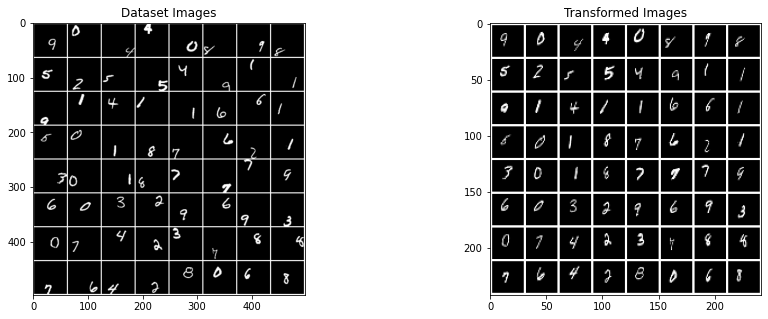

In [118]:
visualize_stn()

tensor([[1.1455, 0.0836, 0.4558],
        [0.1281, 0.8649, 0.0111]])


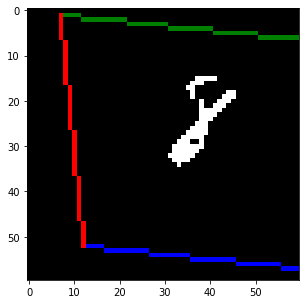

In [141]:
single_batch = next(iter(test_loader))[0].cuda()
with torch.no_grad():
    thetas = model.theta(single_batch)
theta = thetas.cpu()[0]
print(theta)
single_image = single_batch[0,:,:,:].cpu()
with torch.no_grad():
    tformed_single_batch = model.stn(single_batch)
tformed_single_img = tformed_single_batch[0,:,:,:].cpu()
grid = F.affine_grid(theta.view(1, 2, 3), torch.Size([1, *single_image.size()]))
grid = 60*(grid[0] + 1) / 2 # undo normalization of image coordinates
single_pil = transforms.ToPILImage()(single_image)
# clip image, for visualization purposes
thresh = lambda x : 255 if x > 150 else 0
single_pil = single_pil.convert('L').point(thresh, mode='1')
single_pil = single_pil.convert('RGB')
draw = ImageDraw.Draw(single_pil)
# Match colors from the paper
draw.line([*grid[0][0], *grid[0][-1]], fill='green')
draw.line([*grid[0][-1], *grid[-1][-1]], fill='yellow')
draw.line([*grid[-1][-1], *grid[-1][0]], fill='blue')
draw.line([*grid[-1][0], *grid[0][0]], fill='red')
plt.imshow(single_pil)

In [152]:
def get_grid(thetas, idx):
    theta = thetas[idx]
    grid = F.affine_grid(theta.view(1, 2, 3), torch.Size([1, 1, 28, 28]))
    grid = 60*(grid[0] + 1) / 2 # undo normalization of image coordinates
    return grid

def convert_img(single_image):
    single_pil = transforms.ToPILImage()(single_image)
    # clip image, for visualization purposes
    thresh = lambda x : 255 if x > 150 else 0
    single_pil = single_pil.convert('L').point(thresh, mode='1')
    single_pil = single_pil.convert('RGB')
    return single_pil

def draw_box(pil_image, grid):
    draw = ImageDraw.Draw(pil_image)
    # Match colors from the paper
    draw.line([*grid[0][0], *grid[0][-1]], fill='red')
    draw.line([*grid[0][-1], *grid[-1][-1]], fill='green')
    draw.line([*grid[-1][-1], *grid[-1][0]], fill='yellow')
    draw.line([*grid[-1][0], *grid[0][0]], fill='blue')

    return pil_image

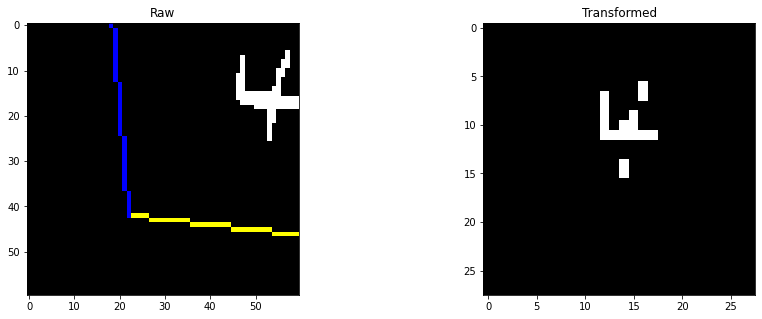

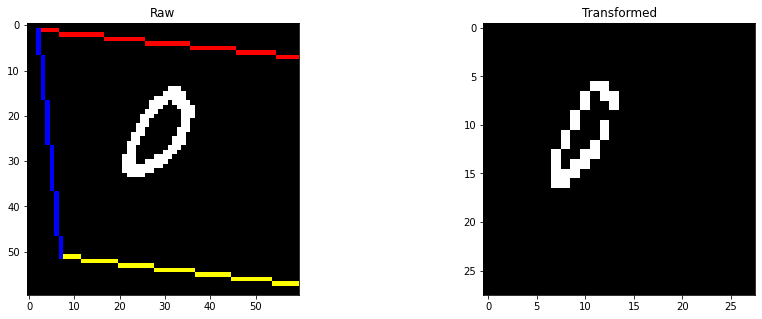

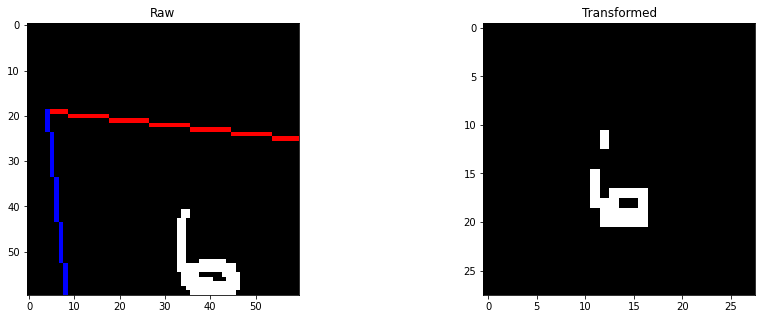

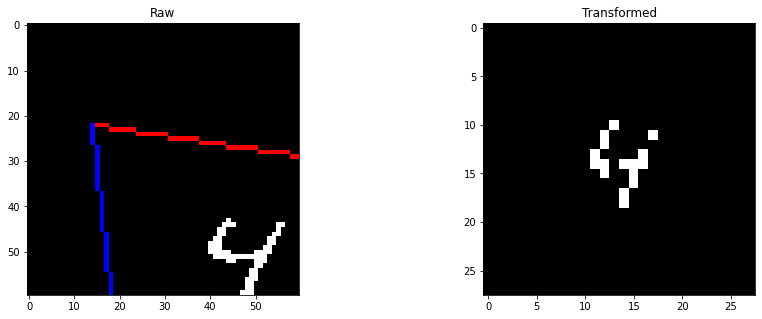

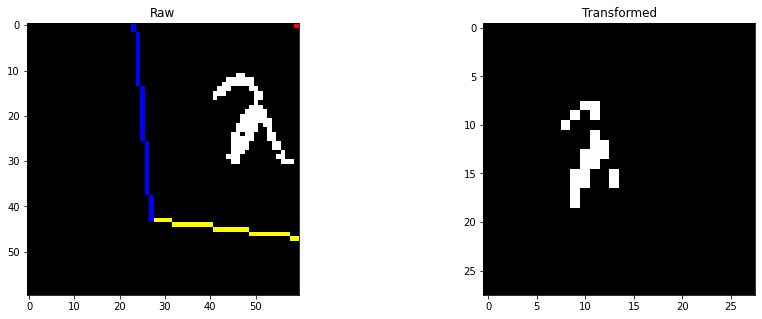

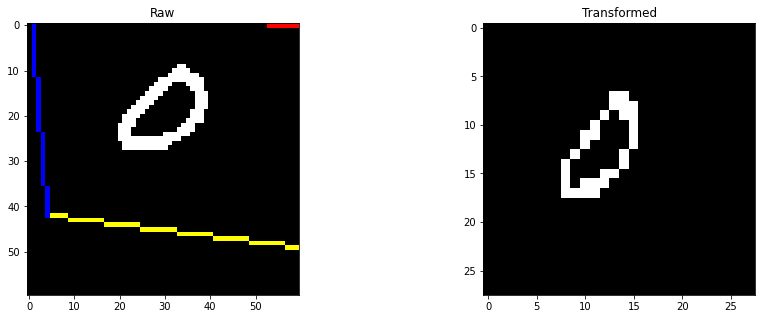

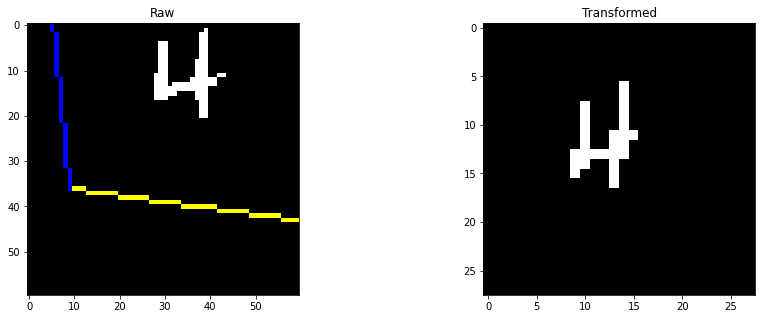

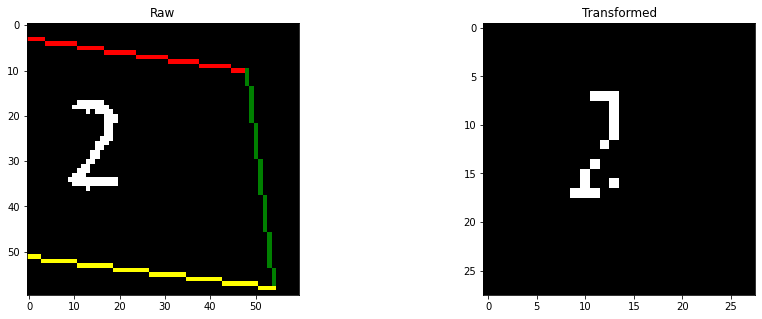

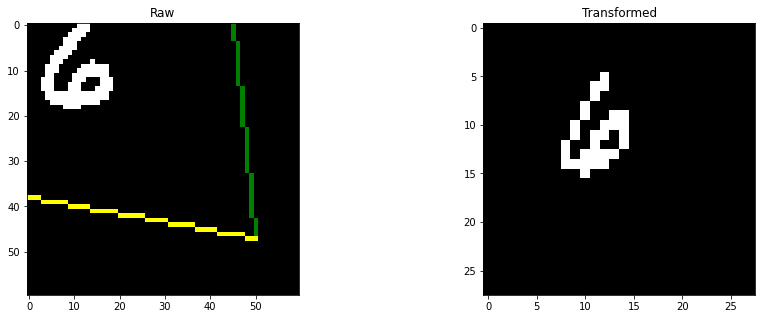

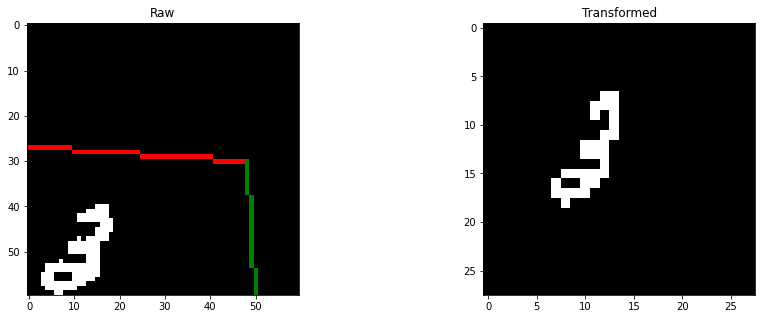

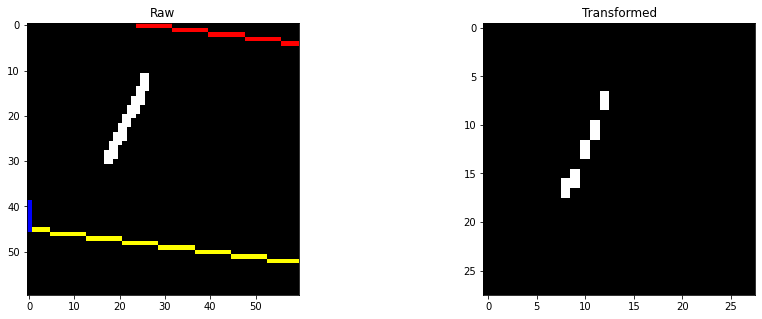

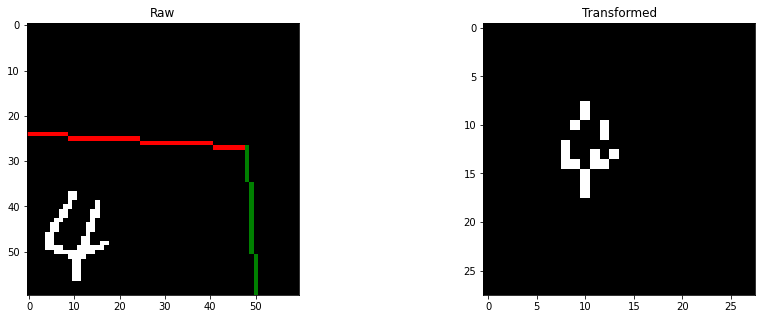

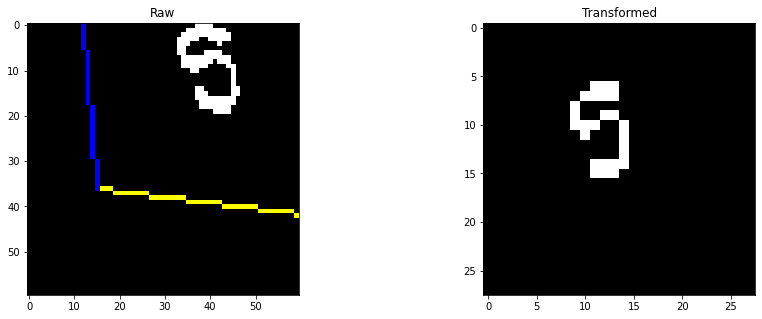

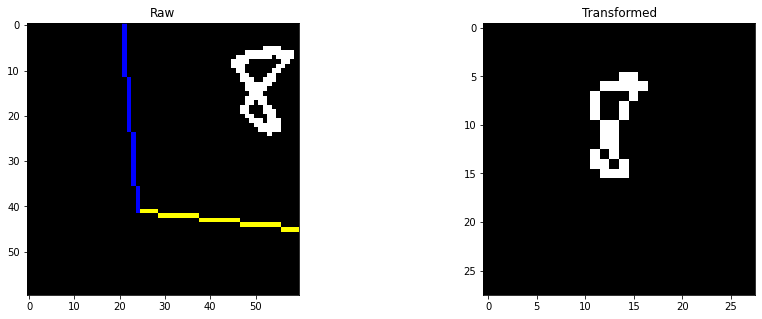

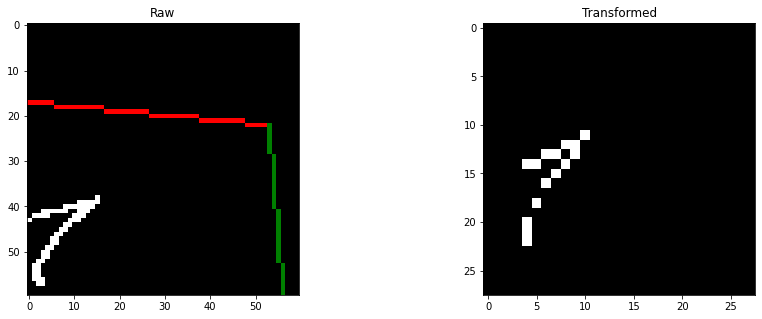

In [163]:
single_batch = next(iter(test_loader))[0].cuda()

with torch.no_grad():
    tformed_batch = model.stn(single_batch)
    thetas = model.theta(single_batch)

single_batch = single_batch.cpu()
tformed_batch = tformed_batch.cpu()
thetas = thetas.cpu()

for i in range(15): # Show only 15 examples
    img = convert_img(single_batch[i,:,:,:])
    grid = get_grid(thetas, i)
    draw_box(img, grid)
    
    tformed_img = convert_img(tformed_batch[i,:,:,:])
    
    _, axs = plt.subplots(1, 2)
    axs[0].imshow(img)
    axs[0].set_title('Raw')

    axs[1].imshow(tformed_img)
    axs[1].set_title('Transformed')
    plt.show()
    